In [9]:
import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score
from datasketch import MinHash, MinHashLSH
import matplotlib.pyplot as plt
import os

palette = sns.color_palette(["#2176AB", "#F97662", "#FFBF00", "#50C878", "#B284BE"])
sns.set_palette(palette)

# Create results directory if it doesn't exist
os.makedirs("results", exist_ok=True)

# Load source tables and generated version metadata
data_dir = Path('data')
benchmark_dir = Path('generated_benchmark')
metadata = pd.read_json(benchmark_dir / "benchmark_metadata.json")

# Load base tables
sources = {
    'movies': pd.read_csv(data_dir / 'movies.csv'),
    'ratings': pd.read_csv(data_dir / 'ratings.csv'),
    'links': pd.read_csv(data_dir / 'movies_links.csv'),
    'tmdb': pd.read_csv(data_dir / 'movie_details.csv')
}


In [10]:

def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union else 0


def analyze_versioned_table_jaccard(version_file):
    df = pd.read_csv(benchmark_dir / version_file)
    target_cols = set(df.columns)
    scores = []
    for name, table in sources.items():
        source_cols = set(table.columns)
        sim = jaccard_similarity(target_cols, source_cols)
        overlap = len(target_cols & source_cols)
        if sim > 0.1:
            scores.append((name, sim, overlap))
    scores.sort(key=lambda x: (-x[1], -x[2]))
    return [s[0] for s in scores[:3]]


def analyze_versioned_table_jaccard_thresh(version_file, threshold=0.1):
    df = pd.read_csv(benchmark_dir / version_file)
    target_cols = set(df.columns)
    selected = []
    for name, table in sources.items():
        source_cols = set(table.columns)
        sim = jaccard_similarity(target_cols, source_cols)
        if sim >= threshold:
            selected.append(name)
    return selected


def build_lsh_index(sources, threshold=0.3, num_perm=256):
    index = MinHashLSH(threshold=threshold, num_perm=num_perm)
    minhashes = {}
    for name, df in sources.items():
        mh = MinHash(num_perm=num_perm)
        for col in df.columns:
            mh.update(col.strip().lower().encode('utf8'))
        minhashes[name] = mh
        index.insert(name, mh)
    return index, minhashes


def analyze_versioned_table_lsh(version_file, index, num_perm=256):
    df = pd.read_csv(benchmark_dir / version_file)
    mh = MinHash(num_perm=num_perm)
    for col in df.columns:
        mh.update(col.strip().lower().encode('utf8'))
    return index.query(mh)


def evaluate(predicted_lists, metadata):
    y_true, y_pred = [], []
    for row in metadata.itertuples():
        gold = []
        if 'ratings' in row.source:
            gold.append('ratings')
        if 'links' in row.source:
            gold.append('links')
        if 'tmdb' in row.source:
            gold.append('tmdb')

        predicted = predicted_lists[row.Index]

        for table in ['ratings', 'links', 'tmdb']:
            y_true.append(1 if table in gold else 0)
            y_pred.append(1 if table in predicted else 0)

    return {
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred)
    }

In [11]:


# Generate predictions using both methods
lsh_index, _ = build_lsh_index(sources)
preds_jaccard = [analyze_versioned_table_jaccard(row.version) for row in metadata.itertuples()]
preds_lsh = [analyze_versioned_table_lsh(row.version, lsh_index) for row in metadata.itertuples()]

# Evaluate both methods
results = {
    'jaccard': evaluate(preds_jaccard, metadata),
    'lsh': evaluate(preds_lsh, metadata)
}

print("\n🔍 Comparative Evaluation of Join Source Detection")
for method, metrics in results.items():
    print(f"\nMethod: {method.upper()}")
    for metric, value in metrics.items():
        print(f"{metric:<10}: {value:.4f}")

# Save results to file
pd.DataFrame(results).to_json(benchmark_dir / "validation_metrics.json", orient='columns', indent=2)

# Combined comparative plot for LSH and Jaccard thresholds
combined_thresholds = np.linspace(0.1, 0.9, 20)

lsh_recs, lsh_pres, lsh_f1s = [], [], []
jacc_recs, jacc_pres, jacc_f1s = [], [], []


def evaluate_extended(predicted_lists, metadata):
    y_true, y_pred = [], []
    for row in metadata.itertuples():
        gold = []
        if 'ratings' in row.source:
            gold.append('ratings')
        if 'links' in row.source:
            gold.append('links')
        if 'tmdb' in row.source:
            gold.append('tmdb')

        predicted = predicted_lists[row.Index]

        for table in ['ratings', 'links', 'tmdb']:
            y_true.append(1 if table in gold else 0)
            y_pred.append(1 if table in predicted else 0)

    return {
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred)
    }



🔍 Comparative Evaluation of Join Source Detection

Method: JACCARD
precision : 0.3333
recall    : 0.7500
f1_score  : 0.4615

Method: LSH
precision : 0.6667
recall    : 0.5000
f1_score  : 0.5714


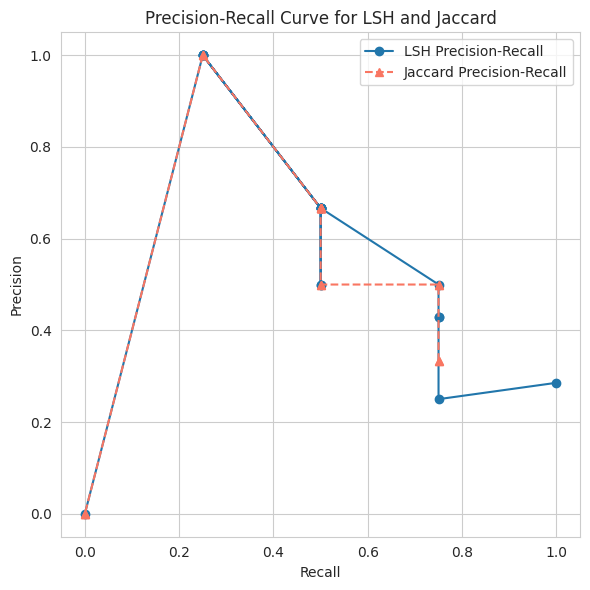

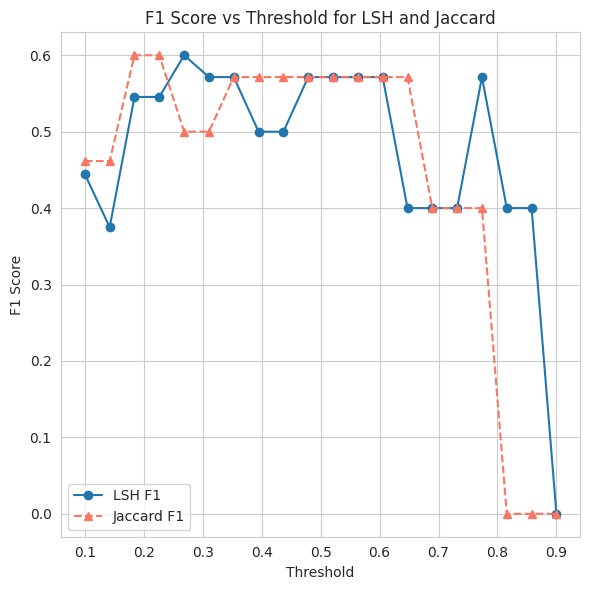

In [12]:

for t in combined_thresholds:
    # LSH Evaluation
    lsh_index_t, _ = build_lsh_index(sources, threshold=t)
    preds_lsh_t = [analyze_versioned_table_lsh(row.version, lsh_index_t) for row in metadata.itertuples()]
    res_lsh = evaluate_extended(preds_lsh_t, metadata)
    lsh_recs.append(res_lsh['recall'])
    lsh_pres.append(res_lsh['precision'])
    lsh_f1s.append(res_lsh['f1_score'])

    # Jaccard Evaluation
    preds_jac_t = [analyze_versioned_table_jaccard_thresh(row.version, threshold=t) for row in metadata.itertuples()]
    res_jac = evaluate_extended(preds_jac_t, metadata)
    jacc_recs.append(res_jac['recall'])
    jacc_pres.append(res_jac['precision'])
    jacc_f1s.append(res_jac['f1_score'])

# Precision-Recall curve
plt.figure(figsize=(6, 6))
plt.plot(lsh_recs, lsh_pres, marker='o', label='LSH Precision-Recall')
plt.plot(jacc_recs, jacc_pres, marker='^', linestyle='--', label='Jaccard Precision-Recall')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for LSH and Jaccard")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/combined_precision_recall_curve.png")
plt.show()

# F1 Score comparison
plt.figure(figsize=(6, 6))
plt.plot(combined_thresholds, lsh_f1s, marker='o', label='LSH F1')
plt.plot(combined_thresholds, jacc_f1s, marker='^', linestyle='--', label='Jaccard F1')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold for LSH and Jaccard")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/combined_f1_threshold.png")
plt.show()
